In [17]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator # for minor ticks
from matplotlib import gridspec
from matplotlib import patches

import numpy as np

from scipy import signal # for convolution
import scipy.stats as scstats
import scipy.special as sps

import pickle

import sys
sys.path.append("../..")

from neuroprob.utils import stats, tools, neural_utils
import neuroprob.models as mdl


dev = tools.PyTorch()

plt.style.use(['paper.mplstyle'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version: 1.6.0+cu101
Using device: cuda:0


In [54]:
### Real data ###
sample_bin, track_samples, x_t, y_t, s_t, dir_t, \
    hd_t, eeg_t, theta_t, pause_ind, pause_size, \
    sep_t_spike, clu_id, t_spike, spike_samples, units, \
    shank_id, local_clu, FR_waveshape, SpkWidthC, \
    refract_viol, isolation_dist, \
    left_x, right_x, bottom_y, top_y = pickle.load(open('../data/datasets/hc5_13.p', 'rb'))

wrap_theta_t = tools.WrapPi(theta_t, True)

In [44]:
pre_x_t = x_t
pre_y_t = y_t

In [50]:
# tracking errors as single points
dx = x_t[1:] - x_t[:-1]
dy = y_t[1:] - y_t[:-1]

for t in range(track_samples-5):
    xx = dx[t:t+4]
    yy = dy[t:t+4]
    
    if np.abs(xx[1]-xx[2]) > (np.abs(xx[0])+np.abs(xx[3]))*2. or np.abs(yy[1]-yy[2]) > (np.abs(yy[0])+np.abs(yy[3]))*2.:
        x_t[t+2] = (x_t[t+1]+x_t[t+3])/2.
        y_t[t+2] = (y_t[t+1]+y_t[t+3])/2.
        print(t)

10305
10316
10325
33672
33683
33697
67605
67612
115833
115846
115859
194470
194490
268825
268832
268835
268838
268841
268844
268851
268854
268857
268863
269856
269877
296938
296941
296946
296949
296952
296957
296960
296968
296971
306790
349455
349470
363548
363560
363575
372703
372706
372714
372719
372724
372727
372732
374502
494717


KeyboardInterrupt: 

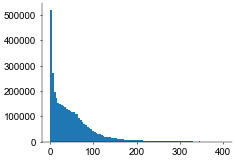

In [57]:
plt.hist(s_t, bins=np.linspace(0, 400, 100))
plt.show()

In [4]:
# regressor correlation
print(stats.corr_lin_lin(x_t, y_t))
print(stats.corr_lin_lin(x_t, s_t))
print(stats.corr_lin_lin(y_t, s_t))

print(stats.corr_circ_circ(dir_t, hd_t))
print(stats.corr_circ_circ(dir_t, theta_t))

print(stats.corr_lin_circ(x_t, theta_t))
print(stats.corr_lin_circ(s_t, theta_t))

0.028386777002903464
0.0592322273078766
0.07958954956762958
-0.15757703608860915
-0.0006284564574182164
1.7018978879653776e-05
0.003943053736834164


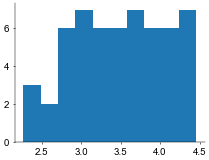

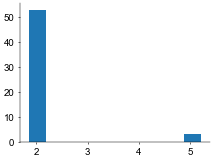

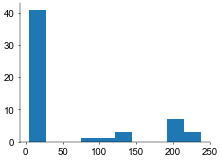

In [13]:
# conditional densities of behavioural variables
conditions = [(x_t, np.array([300.]), 1.0), (y_t, np.array([300.]), 1.0)]

ind_old = None
for c in conditions:
    ind = np.where(tools.metric(c[0], c[1]) < c[2])[0]
    if ind_old is not None:
        ind_old = np.intersect1d(ind_old, ind, return_indices=False)
    else:
        ind_old = np.copy(ind)
        
plt.hist(wrap_theta_t[ind_old])
plt.show()

plt.hist(hd_t[ind_old])
plt.show()

plt.hist(s_t[ind_old])
plt.show()

In [ ]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# get increments
del_x_t = x_t[1:] - x_t[0:-1]
del_y_t = y_t[1:] - y_t[0:-1]

In [ ]:
# test stationarity with augmented Dickey-Fuller
trange = np.arange(0, 100000)

result = adfuller(del_x_t[trange])
print('ADF statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
result = adfuller(del_y_t[trange])
print('ADF statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
AR_model = animal_AR()
AR_model.to(dev)

data = torch.tensor(list(zip(x_t, y_t)), device=dev)
AR_model.fit(data)

In [ ]:
#traj = AR_model.sample_traj(1, 100000, torch.tensor([250.0, 200.0], device=dev))
#traj = traj.to('cpu').data.numpy()
plt.plot((traj[0, :, 0]-traj[0, :, 0].mean())*15 + traj[0, :, 0].mean(), 
         (traj[0, :, 1] - traj[0, :, 1].mean())*15 + traj[0, :, 1].mean())
plt.plot(x_t[:100000], y_t[:100000], alpha=0.3)
plt.show()

print(list(AR_model.parameters()))





In [ ]:
# head direction
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, projection='polar')
#ax.set_rticks([0.04, 0.08, 0.12, 0.16])
ax.set_xlabel('Head angle distribution')
ax.grid(True)
hd_pol = bin_hd[:-1] + delta_bin_hd/2
yy = hd_prob/(bin_hd[1]-bin_hd[0])*np.pi/180.0 # to have integral to one, discrete to density
plt.polar(np.append(hd_pol, hd_pol[0]), np.append(yy, yy[0]), 'r')

# direction
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, projection='polar')
#ax.set_rticks([0.04, 0.08, 0.12, 0.16])
ax.set_xlabel('Movement direction distribution')
ax.grid(True)
dir_pol = bin_dir[:-1] + delta_bin_dir/2
yy = dir_prob/(bin_dir[1]-bin_dir[0])*np.pi/180.0 # to have integral to one, discrete to density
plt.polar(np.append(dir_pol, dir_pol[0]), np.append(yy, yy[0]), 'r')

# speed distribution
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ax.set_ylabel('Frequency')
ax.set_xlabel('Speed (mm/s)')
yy = s_prob/delta_bin_s # to have integral to one, discrete to density
ax.set_ylim(0, yy.max()*1.1)
ax.set_xlim(0, max_speed)
ax.plot(bin_s[:-1], yy, color='r')
d = np.zeros(len(s_prob))
ax.fill_between(bin_s[:-1], yy, where=yy>=d, interpolate=True, color='blue')

# position distribution (time spent)
mm = sp_prob.max()
fig, ax = tools.draw_2d(np.transpose(sp_prob), (11,8), origin='lower', aspect='equal', 
           vmax=mm, ticks=[0, mm//4, mm//2, mm*3//4, mm], ticktitle='Probability', 
           ticklabels=['0', str(int(mm//4)), str(int(mm//2)), 
                       str(int(mm*3//4)), '>{}'.format(int(mm))])
# tu.draw_2d(np.transpose(sp_prob), (12,7), origin='lower', xticks=[], yticks=[], aspect='equal', vmax=sp_prob.max()) same

# dot of the pause locations
ax.scatter(x_t[pause_ind]/delta_bin_x, y_t[pause_ind]/delta_bin_y, marker='.', color='r')

plt.show()

In [ ]:
# EEG analysis of theta modulated by speed/pauses
inds = np.where(theta_t[1:] - theta_t[:-1] < 0)[0] # ends of theta cycles
cycle_bins = inds[1:] - inds[:-1]
cycle_s = []
cycle_times = []
for i in range(len(inds[:-1])):
    cycle_s.append(s_t[inds[i]:inds[i]+cycle_bins[i]].mean())
    cycle_times.append(cycle_bins[i]*sample_bin)
    
plt.scatter(cycle_s, cycle_times, s=1)
plt.show()

p = np.argmax(pause_size)
margin = pause_size[p]*3
time = pause_ind[p] + np.arange(pause_size[p]+2*margin) - margin
plt.plot(time[:margin], eeg_t[time[:margin]], color='b')
plt.plot(time[margin:margin+pause_size[p]], eeg_t[time[margin:margin+pause_size[p]]], color='y')
plt.plot(time[margin+pause_size[p]:2*margin+pause_size[p]], eeg_t[time[margin+pause_size[p]:2*margin+pause_size[p]]], color='b')
plt.show()

# check that head angle and movement direction are correlated
plt.figure()
plt.plot(hd_t[0:200], label='movement')
plt.plot(dir_t[0:200], label='head')
plt.xlabel('Timestep')
plt.ylabel('Angle (rad)')
plt.legend()
plt.show()